# IMAGE CROP 1
**대회 개요**

    - 5개의 인간 장기에 걸쳐 기능 조직 단위(FTU)를 식별,분할.
    - FTU를 가능한 한 정확하게 분할하여 제출
    - 조직 섹션 이미지의 데이터 세트를 사용하여 모델을 구축
    
**IMAGE CROP 1**

    - 이미지를 10등분하여 저장하기

## 라이브러리

In [82]:
print("\tVERSION INFORMATION")
import gc
import os
import cv2; print(f"\t\t– CV2 VERSION: {cv2.__version__}");
import zipfile
from glob import glob
import plotly.express as px
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None; print(f"\t\t– PANDAS VERSION: {pd.__version__}");
from PIL import Image
import tifffile as tiff
from tqdm.notebook import tqdm; tqdm.pandas();
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_io as tfio; print(f"\t\t– TENSORFLOW I/O VERSION: {tfio.__version__}");
gc.enable()

	VERSION INFORMATION
		– CV2 VERSION: 4.5.5
		– NUMPY VERSION: 1.19.5
		– PANDAS VERSION: 1.4.3
		– TENSORFLOW VERSION: 2.4.1
		– TENSORFLOW I/O VERSION: 0.17.0


## 데이터 셋

대회의 목적은 다양한 기관을 촬영한 사진에서 각각 FTU(functional tissue unit)의 위치를 알아내는 것.

훈련 어노테이션은 RLE-인코딩 마스크로 제공된다., 이미지는 16-bit, 회색 스케일, PNG 포맷으로 구성.

다양한 데이터 (2가지 소스)로 구성이 되어있는 것은 다양한 소스에서 나오는 다양한 프로콜과 해상도의 이미지에 대처할 수 있는지를 확인하기 위한 것
- 훈련데이터는 개방된 HPA 데이터
- 공개된 테스트셋은 비공개된 HPA data + HuBMAP data
- 비공개 테스트셋은 HuBMAP data만으로 구성.

# 데이터

## 데이터 세팅

In [2]:
DATA_DIR = "D:Dataset/dataset/hubmap-organ-segmentation/"
print(f"\n... DATA DIRECTORY PATH IS:\n\t--> {DATA_DIR}")
print(f"\n... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")): print(f"\t--> {file}")


... DATA DIRECTORY PATH IS:
	--> D:Dataset/dataset/hubmap-organ-segmentation/

... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:
	--> D:Dataset\dataset\hubmap-organ-segmentation\masked_images
	--> D:Dataset\dataset\hubmap-organ-segmentation\sample_submission.csv
	--> D:Dataset\dataset\hubmap-organ-segmentation\test.csv
	--> D:Dataset\dataset\hubmap-organ-segmentation\test_images
	--> D:Dataset\dataset\hubmap-organ-segmentation\train.csv
	--> D:Dataset\dataset\hubmap-organ-segmentation\train_annotations
	--> D:Dataset\dataset\hubmap-organ-segmentation\train_images


In [3]:
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")                                       # train_image 폴더 path
TRAIN_LABELS_DIR = os.path.join(DATA_DIR, "train_annotations")                               # train_label(json파일) 폴더 path
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")                                                            # train_image(key=id) 정보 csv
train_df = pd.read_csv(TRAIN_CSV)                                                                                  # train_dataframe
all_train_images = glob(os.path.join(TRAIN_IMAGES_DIR, "*.tiff"), recursive=True)   # 모든 train_image
all_train_labels = glob(os.path.join(TRAIN_LABELS_DIR, "*.json"), recursive=True)    # 모든 train_label

TEST_IMAGES_DIR = os.path.join(DATA_DIR, "test_images")                                         # train_image 폴더 path
TEST_CSV = os.path.join(DATA_DIR, "test.csv")                                                              # test_image(key=id) 정보 csv
test_df = pd.read_csv(TEST_CSV)                                                                                    # test_dataframe
all_test_images = glob(os.path.join(TEST_IMAGES_DIR, "*.tiff"), recursive=True)     # 모든 test_image

SS_CSV   = os.path.join(DATA_DIR, "sample_submission.csv")                                     # submission csv
ss_df = pd.read_csv(SS_CSV)                                                                                           # submission dataframe


def rgb2hex(rgb_tuple):
    r,g,b = rgb_tuple
    def clamp(x): 
        return max(0, min(x, 255))
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

ORGANS = ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']
_COLOURS = [(230, 0, 73), (11, 180, 255), (80, 233, 145), (230, 216, 0), (155, 25, 245)]
O2C_MAP = {_o:_c for _o,_c in zip(ORGANS, _COLOURS)}
O2C_HEX_MAP = {_o:rgb2hex(_c) for _o,_c in O2C_MAP.items()}

print("\n... ORIGINAL TRAINING DATAFRAME... \n")
display(train_df)

print("\n... ORIGINAL SUBMISSION DATAFRAME... \n")
display(ss_df)


... ORIGINAL TRAINING DATAFRAME... 



,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male



... ORIGINAL SUBMISSION DATAFRAME... 



,id,rle
0,10078,12 34


## 기본데이터에 데이터 추가

In [4]:
# 변경 (라벨링, 스케일링)
sex2int = {"Male":0, "Female":1}
int2sex = {v:k for k,v in sex2int.items()}
age_divisor = 100.0

train_df["sex"] = train_df["sex"].map(sex2int)
train_df["age"] = train_df["age"]/age_divisor

# 추가 (image, label paths 추가)
train_img_map = {int(x[:-5].rsplit("\\", 1)[-1]):x for x in all_train_images}
train_lbl_map = {int(x[:-5].rsplit("\\", 1)[-1]):x for x in all_train_labels}
test_img_map = {int(x[:-5].rsplit("\\", 1)[-1]):x for x in all_test_images}

train_df.insert(3, "img_path", train_df["id"].map(train_img_map))
train_df.insert(4, "lbl_path", train_df["id"].map(train_lbl_map))
test_df.insert(3, "img_path", test_df["id"].map(test_img_map))

train_df.head()

,id,organ,data_source,img_path,lbl_path,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,0.37,0
1,10274,prostate,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,0.76,0
2,10392,spleen,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,0.82,0
3,10488,lung,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,0.78,0
4,10610,spleen,HPA,D:Dataset/dataset/hubmap-organ-segmentation/tr...,D:Dataset/dataset/hubmap-organ-segmentation/tr...,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,0.21,1


In [5]:
## XLA
print(f"\n... CONFIGURE JIT (JUST IN TIME) COMPILATION ...\n")
# enable XLA optmizations (10% speedup when using @tf.function calls)
tf.config.optimizer.set_jit(True) # XLA은 텐서플로우 환경안에서 도메인 별로 특화된 선형대수 계산 컴파일러이며, 연산 속도와 메모리 사용량을 향상시킨다.


... CONFIGURE JIT (JUST IN TIME) COMPILATION ...



## 함수 

In [21]:
im = Image.open("D:Dataset/dataset/hubmap-organ-segmentation/train_images/10044.tiff")

In [22]:
arr_im = np.array(im)

In [23]:
arr_im.shape

(3000, 3000, 3)

In [25]:
def mask2rle(img, orig_dim=160):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    #Rescale image to original size
    n = Image.fromarray(img)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(float)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):  # fast rle decode
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((1,shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path): # for label data read
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def decode_tiff_tonumpy(img_path): # for tiff image read
    im = Image.open(img_path)
    im = np.array(im)
    return im

## 샘플 데이터 확인

In [28]:
mask = train_df["rle"].iloc[0]

In [29]:
mask = rle_decode(mask, shape=(3000,3000))
mask.shape

(3000, 3000, 1)

In [30]:
 img = decode_tiff_tonumpy(train_df["img_path"].iloc[0]).astype(np.float32)

In [31]:
img.shape

(3000, 3000, 3)

In [42]:
concat_img = tf.concat([img,mask],axis=-1)
concat_img.shape

TensorShape([3000, 3000, 4])

In [58]:
heights = concat_img.shape[0]
widths = concat_img.shape[1]

In [74]:
div_num = 10
height = heights//8
width = widths//8
idx=0
for i in range(8):
    for j in range(8):
        sh = height*i
        sw = width*j
        eh = height*(i+1)
        ew = width*(j+1)
        idx+=1
        img = concat_img[sh:eh,sw:ew,:]

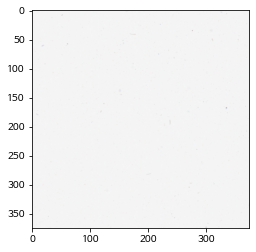

In [80]:
import matplotlib.pyplot as plt
plt.imshow(img[:,:,:3]/255)